In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Import libraries
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications import EfficientNetB0
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout, Input, AveragePooling2D
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from sklearn.metrics import accuracy_score
from tensorflow import keras
from PIL import Image
from skimage import transform

In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/private projects/fruit_veg_detection/archive.zip'

In [4]:
#List of file paths for train, test and validation data

train_dir = Path('/content/fruits-360_dataset/fruits-360/Training')
train_lst = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('/content/fruits-360_dataset/fruits-360/Test')
test_lst = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path('/content/fruits-360-original-size/fruits-360-original-size/Validation')
val_lst = list(test_dir.glob(r'**/*.jpg'))

In [5]:
def df_images(lst_filepaths):
    """ 
    from the list above create a dataframe containing a coulmn of the path and labels of the pictures
    """

    labels = [str(lst_filepaths[i]).split("/")[-2] for i in range(len(lst_filepaths))]

    lst_filepaths = pd.Series(lst_filepaths, name='path').astype(str)
    labels = pd.Series(labels, name='label')

    df = pd.concat([lst_filepaths, labels], axis=1)

    # Shuffle dataframe in-place and reset index 
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [6]:
def print_info(df):
  print("In this dataframe you have {} labels and {} picture to work with".format(len(df.label.unique()), df.shape[0]))


In [7]:
def display_picture(df):
  df2 = df.copy()
  df2 = df2.drop_duplicates(subset=["label"]).reset_index()

  fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(12, 10),
                        subplot_kw={'xticks': [], 'yticks': []})
  
  for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df2.path[i]))
    ax.set_title(df2.label[i], fontsize = 15)
  plt.tight_layout()
  plt.show()



In [8]:
train_df = df_images(train_lst)
test_df = df_images(test_lst)
val_df = df_images(val_lst)

In [9]:
print(train_df)

                                                    path               label
0      /content/fruits-360_dataset/fruits-360/Trainin...         Ginger Root
1      /content/fruits-360_dataset/fruits-360/Trainin...               Salak
2      /content/fruits-360_dataset/fruits-360/Trainin...             Peach 2
3      /content/fruits-360_dataset/fruits-360/Trainin...          Granadilla
4      /content/fruits-360_dataset/fruits-360/Trainin...          Grape Pink
...                                                  ...                 ...
67687  /content/fruits-360_dataset/fruits-360/Trainin...           Tamarillo
67688  /content/fruits-360_dataset/fruits-360/Trainin...          Clementine
67689  /content/fruits-360_dataset/fruits-360/Trainin...  Apple Red Yellow 1
67690  /content/fruits-360_dataset/fruits-360/Trainin...               Limes
67691  /content/fruits-360_dataset/fruits-360/Trainin...   Potato Red Washed

[67692 rows x 2 columns]


In [10]:
print_info(train_df)

In this dataframe you have 131 labels and 67692 picture to work with


In [11]:
print(f'Labels: {train_df.label.unique()}')

Labels: ['Ginger Root' 'Salak' 'Peach 2' 'Granadilla' 'Grape Pink' 'Peach'
 'Mango Red' 'Apple Granny Smith' 'Grape Blue' 'Nut Forest' 'Pepino'
 'Kiwi' 'Pomelo Sweetie' 'Maracuja' 'Onion White' 'Pear Red' 'Plum'
 'Pear Monster' 'Tomato 1' 'Carambula' 'Physalis' 'Potato White'
 'Strawberry' 'Mandarine' 'Apple Red Delicious' 'Nut Pecan' 'Grape White'
 'Grape White 4' 'Cucumber Ripe 2' 'Pepper Green' 'Papaya' 'Walnut'
 'Hazelnut' 'Eggplant' 'Fig' 'Pear Stone' 'Dates' 'Beetroot'
 'Cherry Wax Red' 'Apple Braeburn' 'Physalis with Husk' 'Tomato Maroon'
 'Lemon' 'Banana Lady Finger' 'Apricot' 'Cauliflower' 'Pear'
 'Potato Red Washed' 'Kaki' 'Tomato 3' 'Passion Fruit' 'Huckleberry'
 'Melon Piel de Sapo' 'Cocos' 'Lemon Meyer' 'Plum 3' 'Orange'
 'Apple Red 3' 'Blueberry' 'Pitahaya Red' 'Plum 2' 'Clementine'
 'Pear Kaiser' 'Pear 2' 'Mulberry' 'Cherry Rainier' 'Avocado ripe'
 'Cherry Wax Yellow' 'Pear Williams' 'Guava' 'Tomato Heart' 'Corn'
 'Pepper Yellow' 'Strawberry Wedge' 'Redcurrant' 'Tamarill

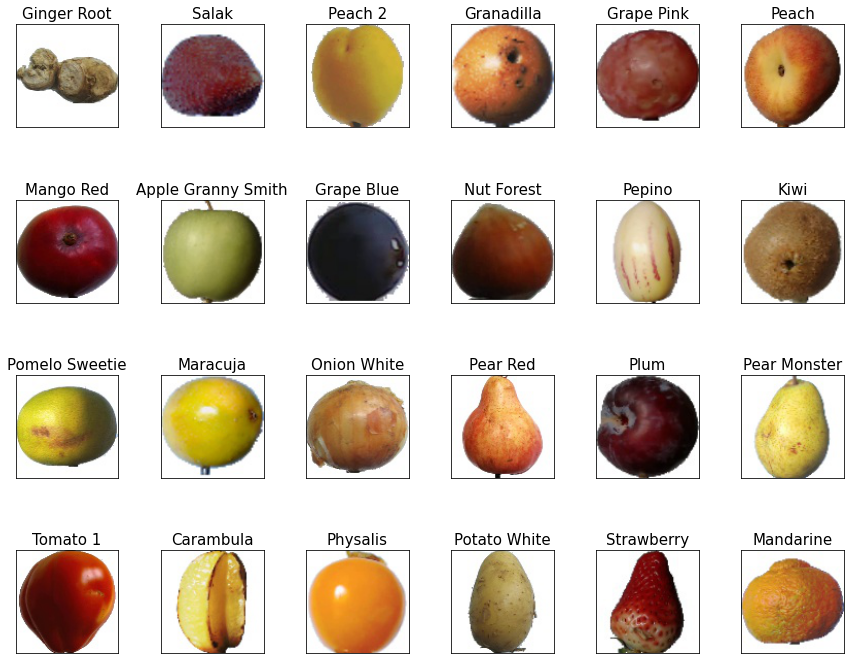

In [12]:
display_picture(train_df)

Generate batches from the dataframes above
source: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

Creating Image batch with tensor shape (32, 224, 224, 3)

32 images

224X224 image size

3 color channels RGB

In [13]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42, #42 the answer to everything :D 
    #rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.1, 0.9),
    shear_range=0.15,
    #horizontal_flip=True, #randomly flip images
    horizontal_flip=False,  #better to set it to False
    vertical_flip=False,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    #rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.1, 0.9),
    shear_range=0.15,
    #horizontal_flip=True,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 67692 validated image filenames belonging to 131 classes.
Found 22688 validated image filenames belonging to 131 classes.
Found 22688 validated image filenames belonging to 131 classes.


Helpful functions

In [14]:
#Create plots of loss and accuracy on the training and validation sets.

def plot_loss_acc(history, epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [15]:
def acc_score_display(model):
  # Predict the label of the test_images
  pred = model.predict(test_images)
  pred = np.argmax(pred,axis=1)

  # Map the label
  labels = (train_images.class_indices)
  labels = dict((v,k) for k,v in labels.items())
  pred = [labels[k] for k in pred]

  y_test = [labels[k] for k in test_images.classes]

  acc = accuracy_score(y_test, pred)
  print(f'Accuracy on the test set: {100*acc:.2f}%')

  # Display some pictures of the dataset with their labels and the predictions
  fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                          subplot_kw={'xticks': [], 'yticks': []})

  for i, ax in enumerate(axes.flat):
      ax.imshow(plt.imread(test_df.path.iloc[i]))
      ax.set_title(f"True: {test_df.label.iloc[i]}\nPredicted: {pred[i]}")
  plt.tight_layout()
  plt.show()
  

In [16]:
  def single_image_pred(model, path):
    img = load_img(path)  
    x = img_to_array(img)
    x = transform.resize(x, (224, 224, 3))
    x = np.expand_dims(x, 0)
    single_pic = test_generator.flow(x, batch_size=1, save_prefix='cat', save_format='jpeg')
    predictions = model.predict(single_pic)
    pred = np.argmax(predictions)
    labels = (train_images.class_indices)
    class_names = dict((v,k) for k,v in labels.items())
    result = "This image is most likely a {} with a {:.2f} percent confidence.".format(class_names[pred], 100 * np.max(predictions))
    
    return result, img


In [17]:
#path for one image
path = '/content/drive/MyDrive/Colab Notebooks/private projects/fruit_veg_detection/test individual image/zuch.jpeg'

First model CNN

In [20]:
model1 = Sequential()
model1.add(InputLayer(input_shape=(224, 224, 3)))
# 1st conv block
model1.add(Conv2D(32, (5, 5), activation='relu', strides=(1, 1), padding='same'))
model1.add(MaxPool2D(pool_size=(2, 2), padding='same'))
# 2nd conv block
model1.add(Conv2D(64, (5, 5), activation='relu', strides=(2, 2), padding='same'))
model1.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model1.add(BatchNormalization())
# 3rd conv block
model1.add(Conv2D(128, (3, 3), activation='relu', strides=(2, 2), padding='same'))
model1.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
model1.add(BatchNormalization())
# 4rd conv block
model1.add(Conv2D(256, (3, 3), activation='relu', strides=(2, 2), padding='same'))
model1.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
model1.add(BatchNormalization())
#add dropout to prevent overfitting
model1.add(Dropout(0.2))
model1.add(Flatten())
# output layer
model1.add(Dense(131, activation='softmax'))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 64)       256       
 ormalization)                                                   
                                                        

In [ ]:
adam = Adam(learning_rate = 0.0001)
model1.compile(
    optimizer=adam,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history1 = model1.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=30,
    callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )]
)

Epoch 1/30
 653/2116 [========>.....................] - ETA: 1:07 - loss: 1.2286 - accuracy: 0.7480

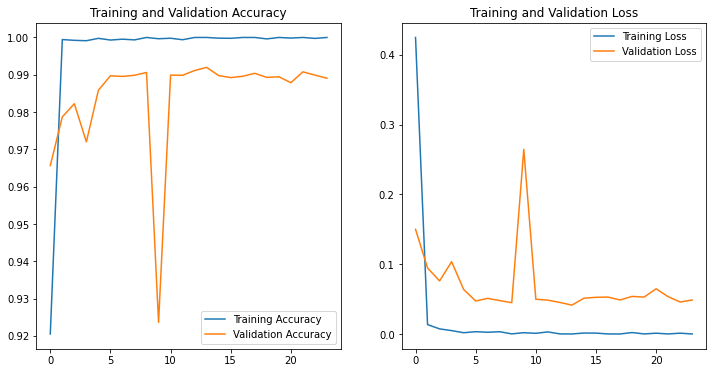

In [ ]:
plot_loss_acc(history1, 24)

709/709 [==============================] - 29s 41ms/step
Accuracy on the test set: 99.20%


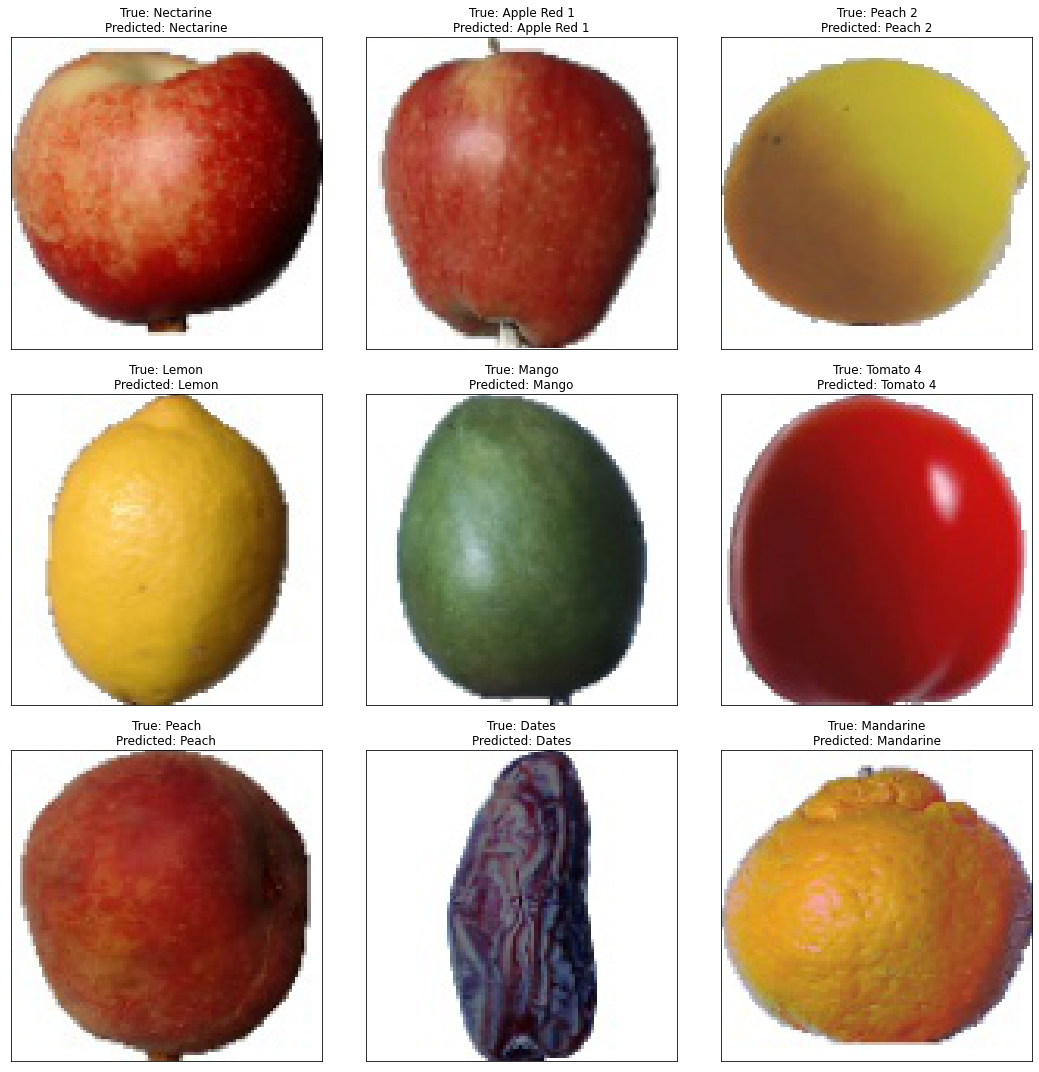

In [ ]:
acc_score_display(model1)

In [ ]:
single_image_pred(model1, path)

1/1 [==============================] - 0s 114ms/step
This image is most likely a Rambutan with a 100.00 percent confidence.


Transfer learning
https://www.tensorflow.org/guide/keras/transfer_learning

In [ ]:
model1.save('/content/drive/MyDrive/Colab Notebooks/private projects/fruit_veg_detection/cnn_model')

Transfer Learning

VGG-16

In [ ]:
vgg = tf.keras.applications.VGG19(
    weights="imagenet",
    input_shape=(224, 224, 3)
)

vgg_layers = vgg.layers

modelvgg = Sequential()
for layer in range(len(vgg_layers)-1):
    modelvgg.add(vgg_layers[layer])

for layer in vgg.layers:
    layer.trainable = False

modelvgg.add(layers.Dropout(0.2))
modelvgg.add(layers.Flatten())
modelvgg.add(layers.Dense(131, activation='softmax'))


modelvgg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [ ]:
adam = Adam(learning_rate = 0.0001)
modelvgg.compile(optimizer=adam,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

historyvgg = modelvgg.fit(train_images, validation_data=val_images,
    batch_size = 32,
    epochs=50,
        callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ])

Epoch 1/50
2116/2116 [==============================] - 127s 56ms/step - loss: 2.9056 - accuracy: 0.4190 - val_loss: 2.0050 - val_accuracy: 0.6717
Epoch 2/50
2116/2116 [==============================] - 117s 55ms/step - loss: 1.3334 - accuracy: 0.7726 - val_loss: 1.3158 - val_accuracy: 0.7847
Epoch 3/50
2116/2116 [==============================] - 119s 56ms/step - loss: 0.8241 - accuracy: 0.8711 - val_loss: 0.9950 - val_accuracy: 0.8306
Epoch 4/50
2116/2116 [==============================] - 117s 55ms/step - loss: 0.5720 - accuracy: 0.9144 - val_loss: 0.8057 - val_accuracy: 0.8463
Epoch 5/50
2116/2116 [==============================] - 118s 56ms/step - loss: 0.4242 - accuracy: 0.9386 - val_loss: 0.6889 - val_accuracy: 0.8633
Epoch 6/50
2116/2116 [==============================] - 115s 54ms/step - loss: 0.3304 - accuracy: 0.9531 - val_loss: 0.6184 - val_accuracy: 0.8728
Epoch 7/50
2116/2116 [==============================] - 115s 54ms/step - loss: 0.2640 - accuracy: 0.9632 - val_loss: 0

In [ ]:
# modelvgg.save("modelvgg.h5")

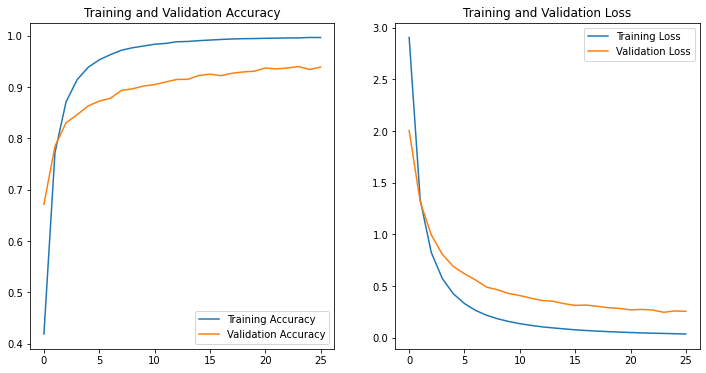

In [ ]:
plot_loss_acc(historyvgg, 26)

709/709 [==============================] - 30s 42ms/step
Accuracy on the test set: 94.01%


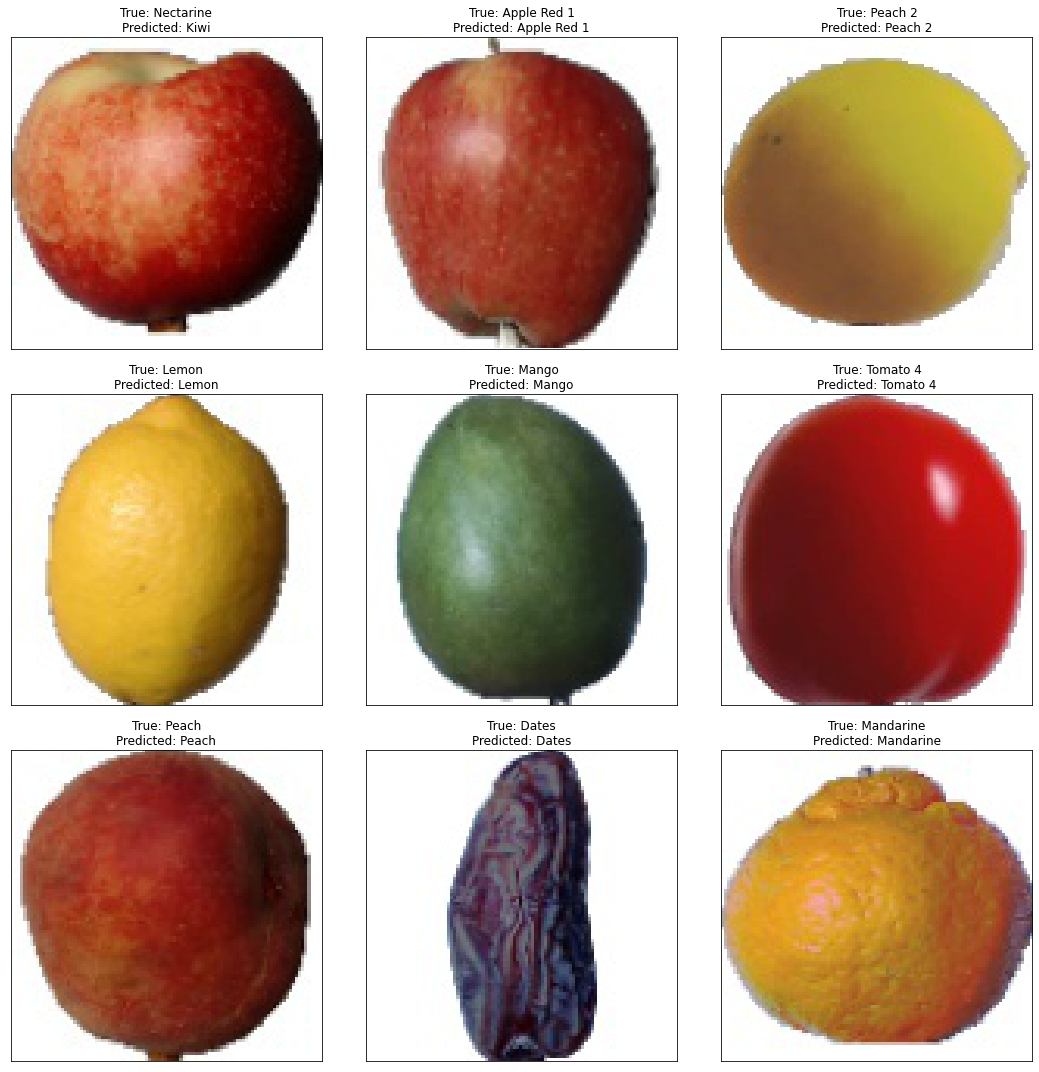

In [ ]:
acc_score_display(modelvgg)

In [ ]:
single_image_pred(modelvgg, path)

1/1 [==============================] - 0s 329ms/step
This image is most likely a Salak with a 100.00 percent confidence.


In [ ]:
modelvgg.save('/content/drive/MyDrive/Colab Notebooks/private projects/fruit_veg_detection/vggmodel')

MobileNetV2

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_tensor=Input(shape=(224, 224, 3))
)

for layer in pretrained_model.layers[:-4]:
  layer.trainable = False

modelmnv2 = Sequential()
modelmnv2.add(pretrained_model)
modelmnv2.add(AveragePooling2D(pool_size=(2, 2)))
modelmnv2.add(Flatten())
modelmnv2.add(Dense(512, activation="relu"))
modelmnv2.add(Dropout(0.5))
modelmnv2.add(Dense(256, activation="relu"))
modelmnv2.add(Dropout(0.5))
modelmnv2.add(Dense(131, activation='softmax'))

modelmnv2.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 average_pooling2d (AverageP  (None, 3, 3, 1280)       0         
 ooling2D)                                                       
                                                                 
 flatten_2 (Flatten)         (None, 11520)             0         
                                                                 
 dense_1 (Dense)             (None, 512)               5898752   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                         

In [ ]:
adam = Adam(learning_rate = 0.0001)
modelmnv2.compile(
    optimizer=adam,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

historymnv2 = modelmnv2.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=30,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]
)

Epoch 1/30
2116/2116 [==============================] - 118s 54ms/step - loss: 1.0710 - accuracy: 0.7464 - val_loss: 0.1520 - val_accuracy: 0.9607
Epoch 2/30
2116/2116 [==============================] - 113s 53ms/step - loss: 0.1051 - accuracy: 0.9704 - val_loss: 0.1219 - val_accuracy: 0.9695
Epoch 3/30
2116/2116 [==============================] - 113s 53ms/step - loss: 0.0573 - accuracy: 0.9829 - val_loss: 0.1176 - val_accuracy: 0.9777
Epoch 4/30
2116/2116 [==============================] - 113s 53ms/step - loss: 0.0351 - accuracy: 0.9892 - val_loss: 0.0793 - val_accuracy: 0.9807
Epoch 5/30
2116/2116 [==============================] - 113s 53ms/step - loss: 0.0266 - accuracy: 0.9921 - val_loss: 0.1231 - val_accuracy: 0.9769
Epoch 6/30
2116/2116 [==============================] - 113s 54ms/step - loss: 0.0240 - accuracy: 0.9931 - val_loss: 0.1392 - val_accuracy: 0.9773
Epoch 7/30
2116/2116 [==============================] - 115s 54ms/step - loss: 0.0185 - accuracy: 0.9943 - val_loss: 0

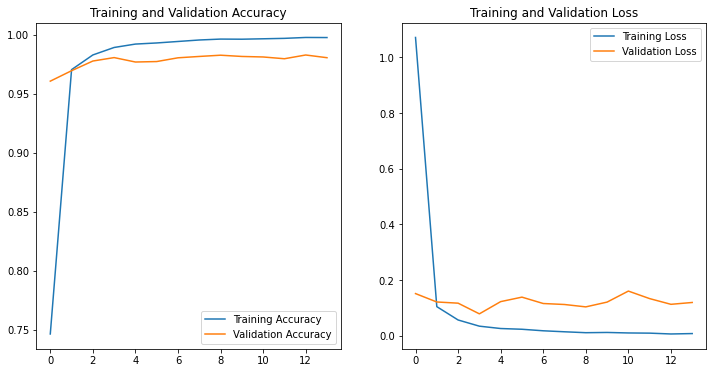

In [ ]:
plot_loss_acc(historymnv2, 14)

709/709 [==============================] - 31s 43ms/step
Accuracy on the test set: 98.07%


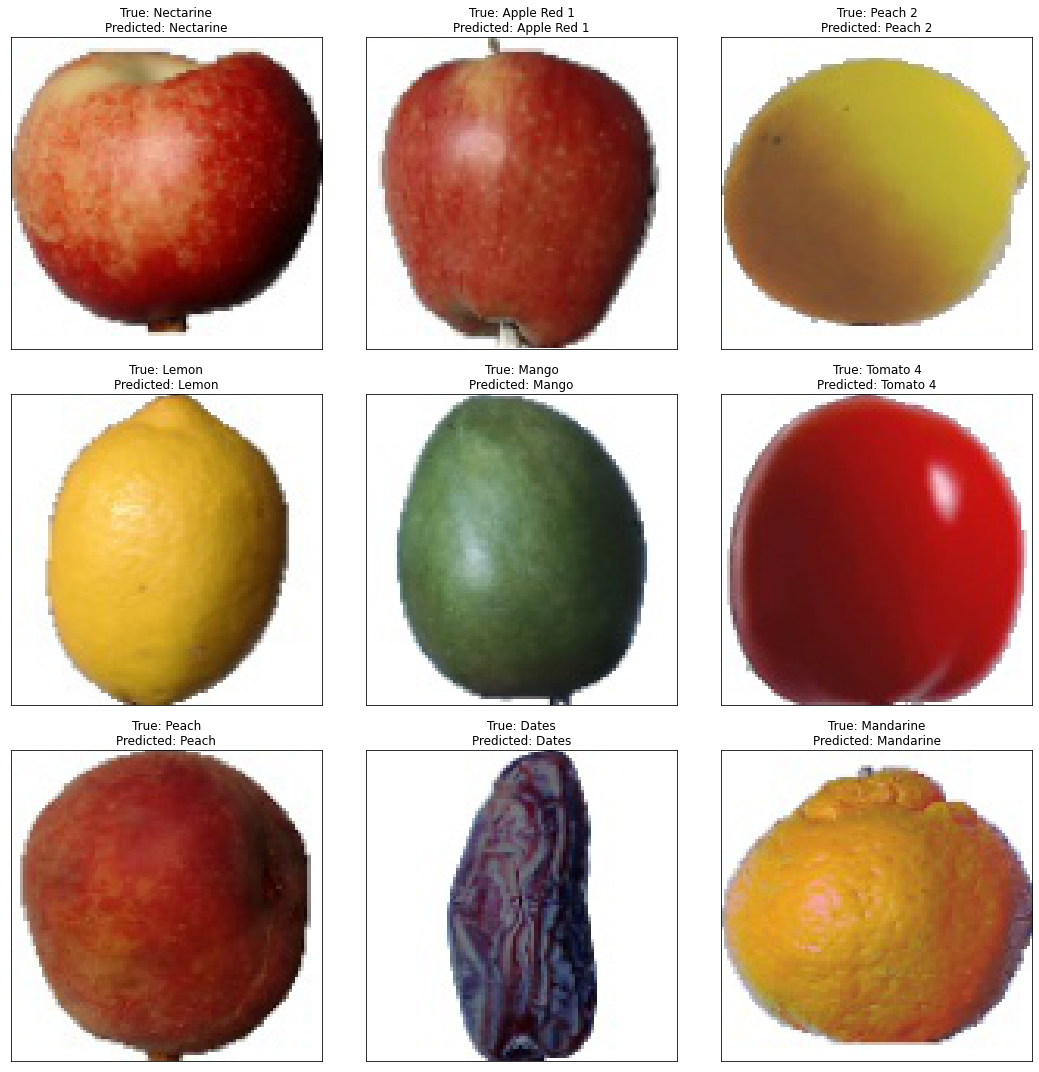

In [ ]:
acc_score_display(modelmnv2)

In [ ]:
single_image_pred(modelmnv2, path)

1/1 [==============================] - 1s 812ms/step
This image is most likely a Nut Forest with a 45.46 percent confidence.


Save models so they can be easily used in the Streamlit app

In [ ]:
modelmnv2.save('/content/drive/MyDrive/Colab Notebooks/private projects/fruit_veg_detection/mobilenet_model')